# Import Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from sklearn import preprocessing
#import os
%matplotlib inline

df = pd.read_csv('/Users/jasongangel/Downloads/AIS/data/WorkOrder7538249_SAIS_2016-01copy.csv', usecols=['MMSI','PERIOD', 'Latitude', 'Longitude','SPEED_KNOTS', 'COG_DEG', 'SHIP_AND_CARGO_TYPE','DRAUGHT'], na_values ='None',low_memory=False, parse_dates=['PERIOD'])

df = df.rename(columns={'Latitude': 'LAT', 'Longitude': 'LONG', 'SHIP_AND_CARGO_TYPE':'SHIP_TYPE'})

# Datashader Plot

CPU times: user 422 ms, sys: 86.6 ms, total: 509 ms
Wall time: 457 ms


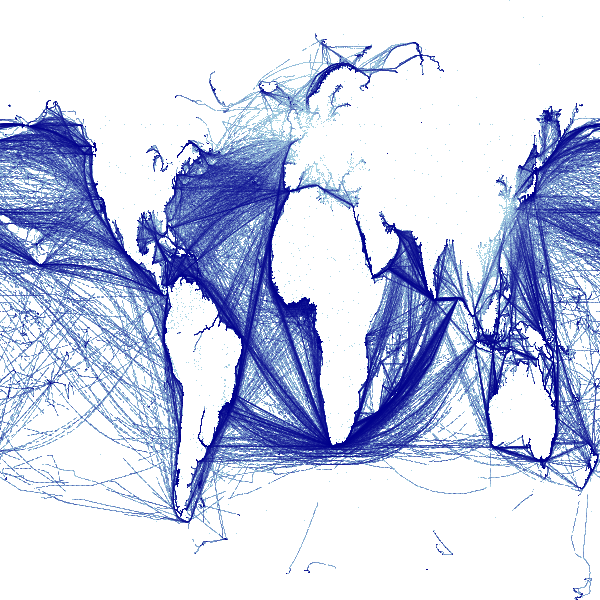

In [2]:
#DATASHADER Plot of LAT/LONGS
import datashader as ds
import datashader.transfer_functions as tf
import dask.dataframe as dd
dd = dd.read_csv('/Users/jasongangel/Downloads/AIS/data/Clean/Clean-01_16*.csv').persist()

canvas = ds.Canvas(plot_width=500, plot_height=300, 
                   x_range=(-8,8), y_range=(-8,8), 
                   x_axis_type='linear', y_axis_type='linear')

%time tf.shade(ds.Canvas().points(dd,'LONG','LAT'))

#  Initial Data Look

In [3]:
df.head(5)

,MMSI,PERIOD,LAT,LONG,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT
0,229454000,2016-01-08 11:50:00,40.374271,-73.103733,15.9,92.0,79,10.0
1,229564000,2016-01-08 11:50:00,34.008233,-56.555884,11.9,73.0,70,13.6
2,229655000,2016-01-08 11:50:00,40.164743,-58.553108,19.1,59.9,70,12.9
3,249904000,2016-01-08 11:50:00,39.218795,-64.369931,18.0,72.1,70,9.9
4,209648000,2016-01-08 11:50:00,42.783833,-52.453734,11.7,290.5,70,16.4


In [4]:
#Dataframe Info (SHIP_TYPE and DRAUGHT contain bad str values in some cells thus they are detected as object types)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7147784 entries, 0 to 7147783
Data columns (total 8 columns):
MMSI           int64
PERIOD         datetime64[ns]
LAT            float64
LONG           float64
SPEED_KNOTS    float64
COG_DEG        float64
SHIP_TYPE      object
DRAUGHT        object
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 436.3+ MB


In [5]:
#Number of Unique Vessels
print(df['MMSI'].nunique(),'Unique Vessels')

27162 Unique Vessels


In [6]:
#Percentage of Rows w/ Missing Data
print((df.isnull().sum().sum()/df.shape[0])*100,'%')

0.8127414034895291 %


In [7]:
#Missing data per column
df.isnull().sum()

MMSI               0
PERIOD             0
LAT                0
LONG               0
SPEED_KNOTS     5610
COG_DEG        21467
SHIP_TYPE          0
DRAUGHT        31016
dtype: int64

# Data clean 

In [8]:
#Copy df
df1 = df.copy()

MMSI

In [9]:
#Remove invalid MMSIs and sort by clean MMSIs
df1=df[(df['MMSI'] > 200000000)].sort_values(['MMSI','PERIOD'])

#Create Country Column from first three digits of MMSI
df1['MMSI'] = df1['MMSI'].astype(str)
df1['COUNTRY'] = df1['MMSI'].str.slice(start=0, stop=3)

SPEED_KNOTS

In [10]:
#Drop null SPEED_KNOTS values
df1.dropna(how='any', axis=0, subset=['SPEED_KNOTS'], inplace=True)

#Drop Rows with speed over 35kts
df1=df1[df1.SPEED_KNOTS <= 35]

COG_DEG

In [11]:
#Forward fill COG_DEG Null values 
df1['COG_DEG'] = df1['COG_DEG'].fillna(method='ffill')

SHIP_TYPE and DRAUGHT

In [12]:
#Fill DRAUGHT null values with 0
df1['DRAUGHT']= df1['DRAUGHT'].fillna(0)

#Cast SHIP_TYPE  and DRAUGHT to numeric type and mark incompatable values as NAN
df1[['SHIP_TYPE','DRAUGHT']] = df1[['SHIP_TYPE','DRAUGHT']].apply(pd.to_numeric,errors='coerce',axis=0)

#Filter out Non Cargo and Tanker vessesls
df1 = df1[(df1['SHIP_TYPE'] >= 70) & (df1['SHIP_TYPE'] <= 89)]

#Cast as a str
df1['SHIP_TYPE'] = df1['SHIP_TYPE'].astype(str)

#Remove second digit of SHIP_TYPE (has no significance)
df1['SHIP_TYPE'] = df1['SHIP_TYPE'].str.slice(start=0, stop=1)

#Cast Back to numeric
df1[['SHIP_TYPE']] = df1[['SHIP_TYPE']].apply(pd.to_numeric,errors='coerce',axis=0)

#Display count of unique vessel types
df1.SHIP_TYPE.value_counts()

7    4995773
8    1620632
Name: SHIP_TYPE, dtype: int64

Downcast int and float Columns

In [13]:
#Round Float Columns to nearest 10th
df1['COG_DEG'] = df1['COG_DEG'].astype(float)
df1.round({'SPEED_KNOTS':1, 'COG_DEG':1,'DRAUGHT':1})

#Downcast float columns
cols = ['SPEED_KNOTS','LAT','LONG','DRAUGHT']
df1[cols] = df1[cols].apply(pd.to_numeric, downcast='float', errors='coerce', axis=0)

#Downcast int columns
cols = ['SHIP_TYPE']
df1[cols] = df1[cols].apply(pd.to_numeric, downcast='signed', errors='coerce', axis=0)

#Drop MMSI Column
#df1 = df1.drop(['MMSI'], axis=1)

# Clean Data Analysis

In [14]:
df1.tail()

,MMSI,PERIOD,LAT,LONG,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT,COUNTRY
7138308,998666200,2016-02-07 23:30:00,-34.763474,-57.892521,0.1,179.4,8,2.5,998
7141345,998666200,2016-02-07 23:35:00,-34.763477,-57.892521,0.1,185.3,8,2.5,998
7143543,998666200,2016-02-07 23:40:00,-34.763878,-57.892624,0.0,175.2,8,2.5,998
7145980,998666200,2016-02-07 23:50:00,-34.764217,-57.892551,0.0,167.3,8,2.5,998
7147783,998666200,2016-02-07 23:55:00,-34.764236,-57.892567,0.1,211.6,8,2.5,998


In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6616405 entries, 125765 to 7147783
Data columns (total 9 columns):
MMSI           object
PERIOD         datetime64[ns]
LAT            float32
LONG           float32
SPEED_KNOTS    float32
COG_DEG        float64
SHIP_TYPE      int8
DRAUGHT        float32
COUNTRY        object
dtypes: datetime64[ns](1), float32(4), float64(1), int8(1), object(2)
memory usage: 359.7+ MB


In [16]:
#Number of Unique Countries
df1['COUNTRY'].nunique()

205

In [17]:
#Check again for null values
df1.isnull().sum()

MMSI           0
PERIOD         0
LAT            0
LONG           0
SPEED_KNOTS    0
COG_DEG        0
SHIP_TYPE      0
DRAUGHT        0
COUNTRY        0
dtype: int64

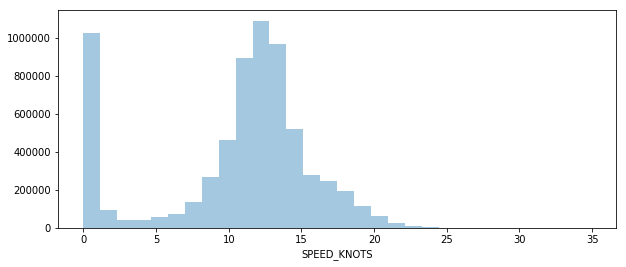

In [18]:
#SPEED_KNOTs Hist
plt.figure(figsize=(10,4))
sns.distplot(df1['SPEED_KNOTS'],kde=False,bins=30)

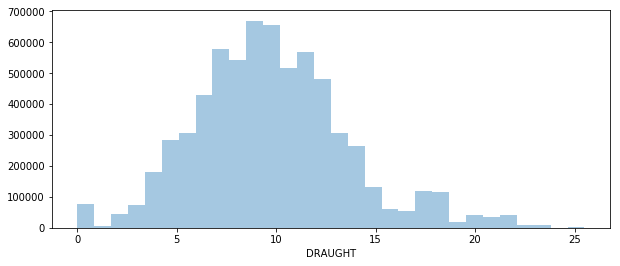

In [19]:
#DRAUGHT Hist
plt.figure(figsize=(10,4))
sns.distplot(df1['DRAUGHT'],kde=False,bins=30)

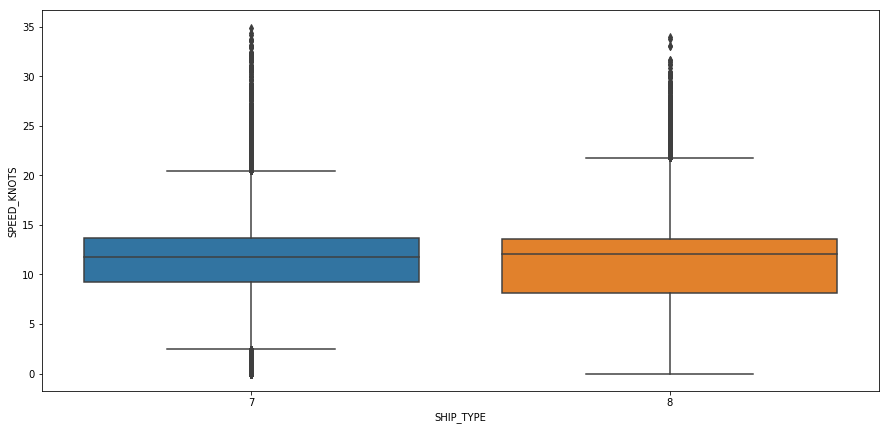

In [20]:
#SPEED_KNOTS by SHIP_TYPE
plt.figure(figsize=(15,7))
sns.boxplot(x='SHIP_TYPE', y='SPEED_KNOTS',data=df1)

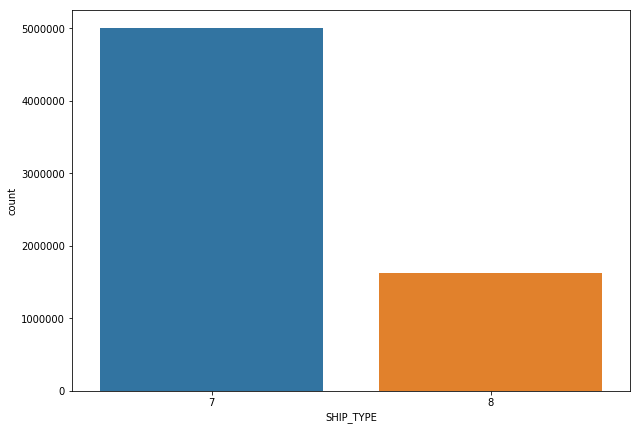

In [21]:
#Box Plot of SHIP_TYPES
plt.figure(figsize=(10,7))
sns.countplot(x='SHIP_TYPE',data=df1)

# Export

In [22]:
#import csv
#df1.to_csv('/Users/jasongangel/Downloads/AIS/data/Clean/Clean-01_16*.csv', index=False, encoding='utf-8')
#quoting=csv.QUOTE_NONE